# **GIS × Python Tutorial Session6 ~ DTMの作成 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
前回の記事ではLidarで取得した、点群データの読み書きや外れ値処理を、"PDAL" というライブラリーで行いました。

https://zenn.dev/daidai_daitai/articles/4071f5aa17cd4b

この記事では、点群データから "DTM" の作成を行いますが、その為に必要な関連知識についてもまとめています。

 - **今回使用するデータ**

 - **Raster**

 - **DTM（Digital Terrain Model）とは**

 - **CSF（Cloth Simulation Filter）アルゴリズム**

 - **DTMの作成**

<br><br><br>




## **今回使用するデータ**
---
今回も "オープンナガサキ" からダウンロードした '.las' データを使用します。前回の記事で出力した、前処理済みのデータを使用します。

<br><br><br>



## **インポート**
---

In [1]:
import json
from pprint import pprint

import geopandas as gpd
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
import pdal
import pyproj
import seaborn as sns
import shapely
import open3d
plt.style.use('ggplot')


FILE_PATH = "../datasets/01ID7913_proj.las"

IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<br><br><br>

## **Raster**
---
"DTM" について知る前に、まずは **`Raster Data（ラスターデータ）`** について知る必要があります。

"Raster Data" とは画像と同じように行列に数値が入力されたデータです。画像を拡大すると格子状に色が並んでいるのが確認できます。この時見える一つ一つの四角を 'セル（ピクセル）'と呼びます。

通常のRGB画像は大抵 '8bit' だと思うので、セルの中には**2の8乗で [0～255] までの整数**が入力されています。

画像を扱った事が無い方は、"Excel" でイメージしてもいいかもしれません。"Excel" の "Sheet" を3枚用意し、「Sheet1にはRed」「Sheet2にはGreen」「Sheet3にはBlue」という名前を付けます。方眼紙の様にセルの形を整え（150px × 100px: 行×列）、そのセルに格子線を引きます。その全てのセルには [0～255] の整数が入力されています。

この数値は色の強さを表すもので、セルA1（座標: 0, 0）が「Sheet Red: 255, Sheet Green: 0, Sheet Blue: 0」ならばそのセルは赤く表示されます。セルA2（座標: 1, 0）が「Sheet Red: 0, Sheet Green: 255, Sheet Blue: 0」ならばそのセルは
濃い緑色に表示されます。ちなみに全てが255ならば白になり、全てが0ならば黒になります。

これはRGB画像の場合ですが、"Raster Data" で表すものによっては、上で示した3次元のデータではなく、2次元の行列にFloat型の数値が入力されていたりします。

"Raster Data" には普通の画像とは違い、座標の情報が付与されていますのでGISのアプリなどで、"Vector Data" など重ねて見る事が出来ます。

座標の情報と形を保有している "Vector Data" とは違い、"Raster Data" のセルの大きさは決まっていますので、セルの大きさ（例えば 10m×10m）よりも小さな情報を表現する事は出来ませんので、拡大しすぎると劣化してしまいます。

実際に簡単なデータを作成して、イメージを確認してみましょう。

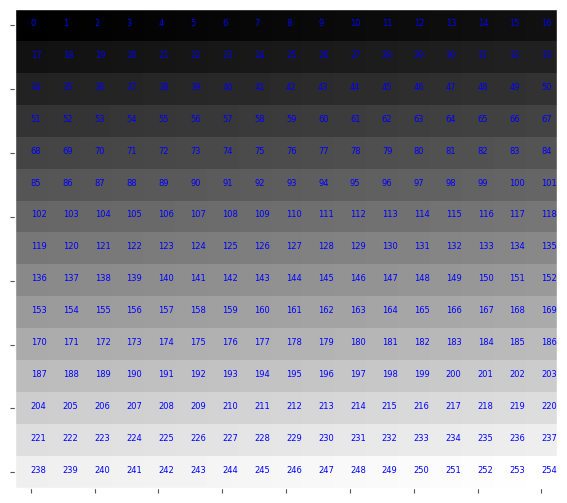

In [2]:
width = 17
height = 15
values = list(range(0, 255))
image = []
for h in range(0, height):
    _lst = []
    for w in range(0, width):
        _lst.append(values.pop(0))
    image.append(_lst)


values = list(range(0, 255))
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
for h in range(height):
    for w in range(width):
        plt.text(w, h, values.pop(0), color='blue', fontsize=6)

plt.tick_params(
    labelbottom=False, labelleft=False, 
    labelright=False, labeltop=False
)
plt.grid();

1つ足りませんが、イメージは掴めましたでしょうか？

黒の方が値が小さい理由は、調べた事が無いので想像ですが、恐らく光の反射の強さを表す為だと思います。

<br><br><br>

## **DTM（Digital Terrain Model）とは**
---
**`DTM（Digital Terrain Model）`** とは、**地形の高さを表すRasterData**の事で、"DEM（Digial Elevation Model）" と表記される場合もあります。

国土地理院の "基盤地図情報ダウンロードサービス" でもこのDTMは公開されていますが、全国を網羅しているのは10mメッシュ（格子の大きさ）だけです。5mメッシュのDTMや、最近では1mメッシュのデータも公開され始めていますが、まだまだ整備は進んでいません（2024-05現在）。航空機やドローンに搭載したLidarであればもっと詳細な地形のデータを取得する事が可能です（地面までレーザーが届けば）。

しかしLidarで取得した点群データには、地形の点だけが保存されている訳ではありません。そして点には当たった物体のラベルがにゅりょっくされている訳でもありません。

まずはデータを見ていきましょう。

In [3]:
sentence = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': FILE_PATH
        }
    ]
}

js = json.dumps(sentence)
pipeline = pdal.Pipeline(js)
pipeline.execute()

df = pipeline.get_dataframe(0)
print(df.columns)

Index(['X', 'Y', 'Z', 'Intensity', 'ReturnNumber', 'NumberOfReturns',
       'ScanDirectionFlag', 'EdgeOfFlightLine', 'Classification', 'Synthetic',
       'KeyPoint', 'Withheld', 'Overlap', 'ScanAngleRank', 'UserData',
       'PointSourceId', 'GpsTime', 'Red', 'Green', 'Blue'],
      dtype='object')


様々な要素が記録されていますが、どの様な値が入力されているのでしょうか、要約統計量を見てみます。

しかし、記事に書くならば情報量が少ない方が良いので、一意な値が1種類しかない列は削除してから、要約統計量を計算します。

In [4]:
del_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        del_cols.append(col)

df.drop(del_cols, axis=1).describe()

,X,Y,Z,Intensity,Red,Green,Blue
count,6.684581e+06,6.684581e+06,6.684581e+06,6.684581e+06,6.684581e+06,6.684581e+06,6.684581e+06
mean,-3.484883e+03,3.786842e+04,3.154098e+02,1.676435e+02,2.039356e+04,2.492939e+04,2.461110e+04
std,2.881643e+02,2.167067e+02,6.870297e+01,6.171454e+01,8.347706e+03,6.574588e+03,5.020807e+03
min,-4.000000e+03,3.750000e+04,1.428500e+02,0.000000e+00,5.140000e+02,7.196000e+03,1.799000e+03
25%,-3.731850e+03,3.768077e+04,2.672600e+02,1.340000e+02,1.310700e+04,1.927500e+04,2.081700e+04
50%,-3.475220e+03,3.786558e+04,2.959000e+02,1.790000e+02,1.927500e+04,2.415800e+04,2.364400e+04
75%,-3.233750e+03,3.805521e+04,3.566900e+02,2.120000e+02,2.698500e+04,2.981200e+04,2.775600e+04
max,-3.000000e+03,3.825000e+04,5.196200e+02,2.550000e+02,6.553500e+04,6.553500e+04,6.553500e+04


出力したデータを見てみると、「X（横座標）」「Y（縦座標）」「Z（高さ）」「Intensity（反射強度）」「Red（赤色の強さ）」「Green（緑色の強さ）」「Blue（青色の強さ）」だけでした。ちなみにこの色情報の最大値は2の16乗の範囲内なので16bitの色情報だと推測できます。

反射強度について分析した事が無いのでアレですが、これでは地面の点を抽出する事は出来ない様に思えます。

では、どのようにして **「地面かそれ以外か」** の分類を行うのでしょうか。
<br><br><br>

## **CSF（Cloth Simulation Filter）アルゴリズム**
---
"PDAL" の "filters" 関数には様々なクラスタリング方法がありますが、今回は **`CSF（Cloth Simulation Filter）`** を使用して「地上かそれ以外か」を分類する方法について、簡単に解説していきます。

点群データを「地面かそれ以外か」に分類するステップは非常に重要なタスクです。クラスを分ける事で、"DTM" や "DSM" を作成する事が出来ますし、その間にある点群は内部の構造を表していると考える事も出来ます。

"CSF" は名前に含まれている通り、"Cloth（布）"を使用して地面を分類します。点群を反転させそこに仮想 "Cloth" を落下させる物理プロセスをシュミレーションする事により、点群の中から地表面とそれ以外とを分類しフィルタリングします。

まずは以下の画像を見てください。この画像の青い線をLidarで取得した点群データだと考えます。

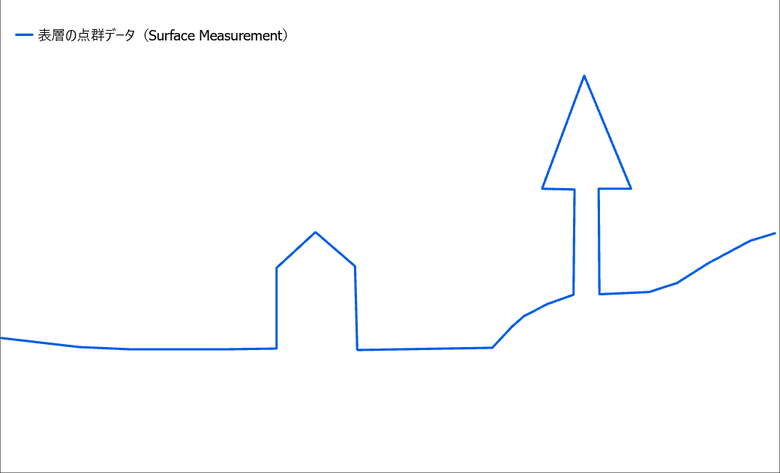

In [7]:
Image(r'../Images/CSF_01_RawData.png')

### 1. **計測データの反転 ...**
計測したデータの上下を反転させます。レーザーは光ですので、色の濃い物体を透過する事はありません。したがって建物や樹冠、地面などの表面に当たり、反射したものが記録されています。このデータを反転させ、ある断面を見てみると、建物に当たった場所は凸から凹に変わっているはずです。

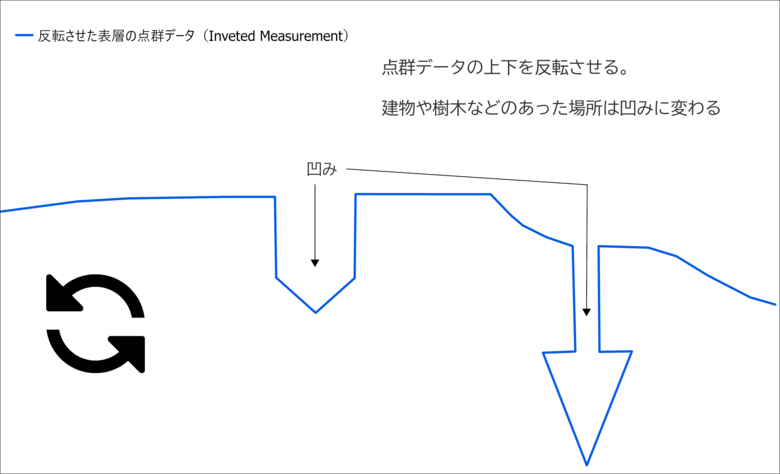

In [8]:
Image(r'../Images/CSF_02_Reversed.png')

### **クロスシュミレーション ...**

反転したデータに対して、Clothを置きます。Clothが重力で落下し、反転した点群の上に覆いかぶさるようなイメージです。

Clothの硬度をハンカチ程の柔らかさだと仮定すると、そのClothは表面を撫でる様にぴったりと反転した地表面にくっついているはずです。また、Clothのノードよりも小さな凹みにはClothは落ちていきませんし、柔らかなClothは地形の変化に対応し、その形を変えます。このClothの形状は、最終的には地形の形を表すDTMとなります。

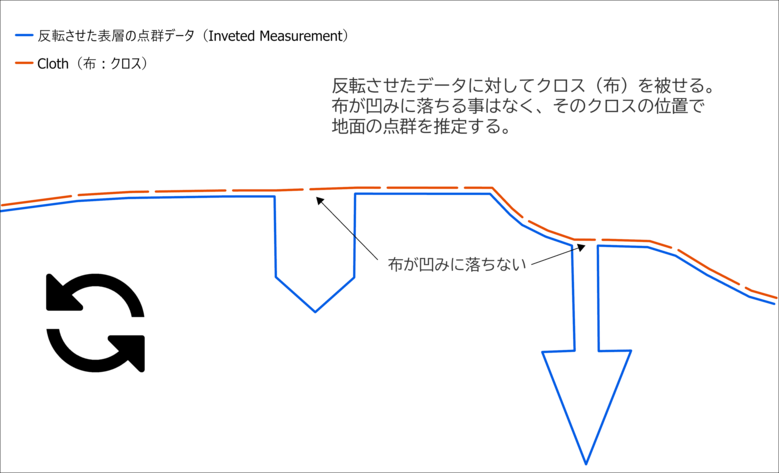

In [9]:
Image(r'../images/CSF_03_ClothSimulation.png')

## Clothの硬度


[An Easy-to-Use Airborne LiDAR Data Filtering Method Based on Cloth Simulation](https://www.mdpi.com/2072-4292/8/6/501)

[ICSF: An Improved Cloth Simulation Filtering Algorithm for Airborne LiDAR Data Based on Morphological Operations](https://www.mdpi.com/1999-4907/14/8/1520)

[An Adaptive Surface Interpolation Filter Using Cloth Simulation and Relief Amplitude for Airborne Laser Scanning Data](https://www.mdpi.com/2072-4292/13/15/2938)